In [1]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from skopt.space import Real, Categorical, Integer

from bcnf.utils import partconv1d, get_gaussian_kernel

In [2]:
# Example search spaces
search_spaces = {
    'condition_size': Integer(1, 2048),
    'model_hidden_size': Integer(32, 256),
    'model_n_blocks': Integer(1, 64),
    'model_act_norm': Categorical([True, False]),
    'feature_network_hidden_size': Integer(16, 2048),
    'feature_network_hidden_layers': Integer(0, 16),
    'feature_network_dropout': Real(0, 0.5),
}

In [3]:
checkpoint_file = 'checkpoint.pkl'
metrics_dir = 'metrics'

In [4]:
with open(checkpoint_file, 'rb') as f:
    checkpoint = pickle.load(f, errors='ignore')

In [5]:
metrics = {}
for metrics_file in os.listdir(metrics_dir):
    with open(os.path.join(metrics_dir, metrics_file), 'rb') as f:
        metrics[os.path.splitext(metrics_file)[0].replace('params_', '')] = pickle.load(f)

In [6]:
rows = [params + [value] for params, value in zip(checkpoint['x_iters'], checkpoint['func_vals'])]

In [7]:
hyper_df = pd.DataFrame(rows, columns=list(search_spaces.keys()) + ['val_loss_upper_bound'])

In [8]:
hyper_df['configuration_name'] = hyper_df.apply(lambda row: "_".join([str(p) for p in row.values[:-1]]), axis=1)

In [9]:

# Set all columns in 'loss' that are = 100 to nan
hyper_df.loc[hyper_df['val_loss_upper_bound'] == 100, 'val_loss_upper_bound'] = None

hyper_df['feature_network_dropout'] = hyper_df['feature_network_dropout'].round(2)
hyper_df['val_loss_upper_bound'] = hyper_df['val_loss_upper_bound'].round(3)

In [10]:
hyper_df.sort_values('val_loss_upper_bound')

,condition_size,model_hidden_size,model_n_blocks,model_act_norm,feature_network_hidden_size,feature_network_hidden_layers,feature_network_dropout,val_loss_upper_bound,configuration_name
11,1329,220,12,True,321,3,0.45,-45.773,1329_220_12_True_321_3_0.4493191096581155
24,1700,195,12,True,289,3,0.47,-45.746,1700_195_12_True_289_3_0.47366827208363227
9,1329,249,12,True,306,3,0.42,-43.838,1329_249_12_True_306_3_0.4154755611680499
15,2048,128,12,True,16,3,0.50,-43.154,2048_128_12_True_16_3_0.49577332352255077
17,2007,256,14,True,16,3,0.25,-43.001,2007_256_14_True_16_3_0.24800871821724724
3,505,208,23,True,494,13,0.33,-41.240,505_208_23_True_494_13_0.32550896917789723
14,641,247,12,True,696,3,0.50,-40.491,641_247_12_True_696_3_0.5
20,1252,168,19,True,16,13,0.11,-39.394,1252_168_19_True_16_13_0.11258910442555435
16,2023,49,11,True,16,3,0.46,-39.044,2023_49_11_True_16_3_0.45721922259759906
25,2048,199,15,True,307,3,0.37,-38.333,2048_199_15_True_307_3_0.3744589103909165


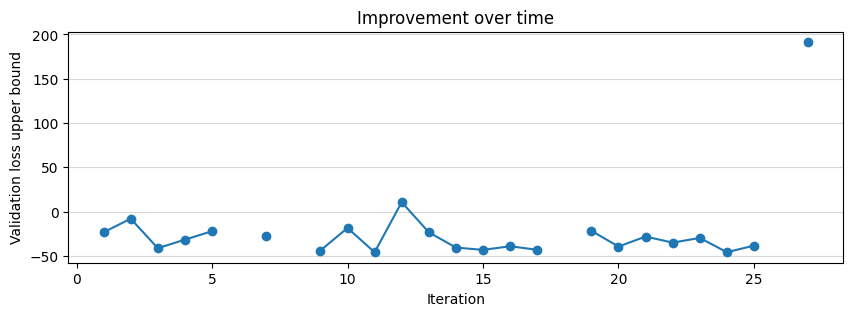

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(hyper_df['val_loss_upper_bound'], '-o')
ax.set_title('Improvement over time')
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation loss upper bound')
ax.grid(axis='y', alpha=0.5)

In [12]:
# configuration = list(metrics.keys())[4]
# configuration = "1700_195_12_True_289_3_0.47366827208363227"
configuration = hyper_df.sort_values('val_loss_upper_bound').iloc[0]['configuration_name']

Text(0.5, 0.98, '1329_220_12_True_321_3_0.4493191096581155')

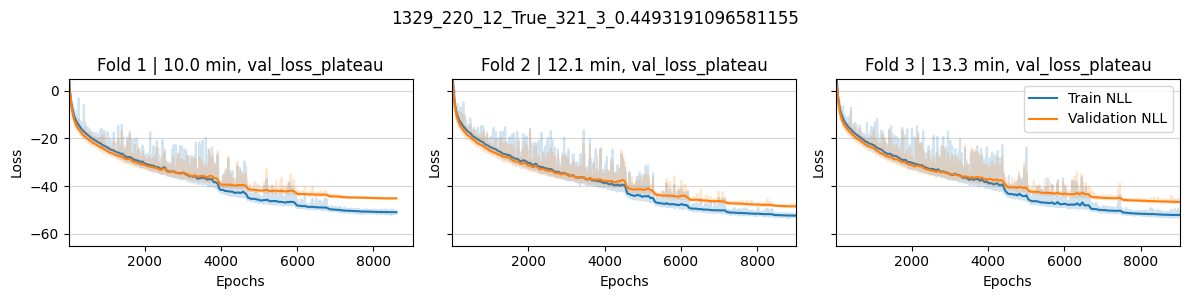

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=True)

for i, ax in enumerate(axes):
    loss_history = metrics[configuration][i]['loss_history']
    epochs = np.array([e for e, _ in loss_history['train']])
    losses = np.array([l for _, l in loss_history['train']])

    ax.plot(epochs, losses, alpha=0.2, color='C0')
    ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=128)), label='Train NLL', color='C0')

    epochs = np.array([e for e, _ in loss_history['val']])
    losses = np.array([l for _, l in loss_history['val']])

    ax.plot(epochs, losses, alpha=0.2, color='C1')
    ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=32)), label='Validation NLL', color='C1')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

    # ax.set_xscale('log')
    ax.set_ylim(None, 5)
    ax.set_xlim(1, None)
    ax.grid(axis='y', alpha=0.5)

    time_taken = loss_history['time'][-1][1] - loss_history['time'][0][1]
    ax.set_title(f'Fold {i+1} | {time_taken / 60:.1f} min, {loss_history["stop_reason"]}')

axes[-1].legend();

fig.tight_layout()
fig.subplots_adjust(top=0.75)
fig.suptitle(configuration)